In [1]:
import sys
#sys.path.append("~/Documents/qubitlab/python/qutip")
from libqubit2d import *
from scipy.optimize import *
from scipy.integrate import *

In [2]:
import random
import math

In [3]:
class ND(Model):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    class_params = ['params']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.evals, self.evecs = self.Hq().eigenstates()
        self.params['w'] = self.evals[1] - self.evals[0]
        self.params['psi0'] = self.evecs[0]
        self.update_pulse(params={'w':self.params['w']})
        return self
    def n(self):
        return num(2*self.params['N']+1, offset = -self.params['N'])

    def I(self):
        return identity(2*self.params['N']+1)

    def Hc(self):
        return 2*np.pi*4*self.params['Ec']*(self.n())**2

    def Hj(self):
        return -0.5*2*np.pi*self.params['Ej']*Qobj(np.diag(np.ones(2*self.params['N']), -1)+np.diag(np.ones(2*self.params['N']), 1))

    def Hq(self):
        return self.Hc() + self.Hj()

    def c(self):
        return sum([self.n().matrix_element(self.evecs[j], self.evecs[j+1])/self.n().matrix_element(self.evecs[0], self.evecs[1])\
                        * self.evecs[j]*self.evecs[j+1].dag() for j in range(0, len(self.evecs)-1)])
    def get_anharmonism(self, recount = False):
        if recount:
            self.evals, self.evecs = self.Hq().eigenstates()
        return -(self.evals[2] - self.evals[1]) + (self.evals[1] - self.evals[0])
    def collapse_list(self, c_op = None):
        collapse_list = []
        if c_op is None:
            c_op = self.c()
        if(self.params['gamma_m']> 0):
            collapse_list.append(np.sqrt(self.params['gamma_m']) * c_op )
        return collapse_list

    def S_basis(self):
        S = [[el[0] for el in evec.data.toarray()] for evec in self.evecs ]
        return Qobj(S)
    
    def raise_dim_2toN(self,A2d,base = 'zero'):
        B2d = A2d.data.toarray()
        A = base
        if base is 'zero':
            A = np.zeros(shape=(len(self.evecs),len(self.evecs)),dtype=np.complex128)
        A[0][0] = B2d[0][0]
        A[0][1] = B2d[0][1]
        A[1][0] = B2d[1][0]
        A[1][1] = B2d[1][1]
        Aq = Qobj(A)
        return Aq
    
    def convert_2toN(self, A2d):
        B2d = A2d.data.toarray()
        A = np.zeros(shape=(len(self.evecs),len(self.evecs)),dtype=np.complex128)
        A[0][0] = B2d[0][0]
        A[0][1] = B2d[0][1]
        A[1][0] = B2d[1][0]
        A[1][1] = B2d[1][1]
        Aq = Qobj(A)
        return Aq.transform(self.evecs,True)

    def Hq_evecs(self):
        return self.Hq().eigenstates()[1]
    def Hq_evals(self):
        return self.Hq().eigenstates()[0]

    def rotatingFrame(self, expected_ops,  output = None):
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        output.expect = []
        for i in range(len(expected_ops)):
            output.expect.append([])
        Hq = self.Hq()
        for i, eop in enumerate(expected_ops):
            output.expect[i] = [ expect((-1j*Hq * time).expm() * eop * (1j*Hq * time).expm(), state) for time, state in zip(self.timelist(),output.states) ]
        return output
    def rotateStates(self,output = None):
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        szn = self.convert_2toN(sigmaz())
        U = (-1j*self.Hq()* 0).expm()
        dt = self.timelist()[-1] / (len(self.timelist())-1)
        new_states = []
        Hq = self.Hq()
        output.states = [(1j*Hq * time).expm() * state for time, state in zip(self.timelist(), output.states)]
            
        #for time_step, state in enumerate(output.states):
        #    time = dt * time_step
        #    U  = (-1j*Hq * time).expm()
        #    new_states.append( U * output.states[i])
        #output.states = new_states
        return output
    def expectOperators(self, expected_ops2d = [sigmax(),sigmay(),sigmaz()], output = None):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        output.expect = []
        for i in range(len(expected_ops)):
            output.expect.append([])
        for state in output.states:
            for i, eop in enumerate(expected_ops):
                output.expect[i].append(expect(eop, state))    
        return output

In [4]:
class EasyShiftable:
    def shift(self, deltat):
        self.update(params={'a': self.params['a'] + deltat, 'b': self.params['b'] + deltat})
    def get_left(self, EPS = 1e-5):
        return self.params['a']
    def get_right(self, EPS = 1e-5):
        return self.params['b']

In [5]:
class PulseNXY(Pulse, EasyShiftable):
    aroundX = 0
    aroundY = np.pi/2
    EPS = 1e-5
    default = Empty()
    default.params = {
        'f' : 0.1,
        'a':2.5,
        'b':2.5 + 3.92,
        'st':0.001,
        'phase':0,
        'axe' : aroundX
    }
    default.shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st) )*cos(w*t + axe )"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100),
        'auto' : True
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra']
    def get_shape(self):
        return self.shape
    def contour(self, offset=0):
        spf = sp.sympify(self.get_shape())/sp.sympify("cos(w*t+axe)") + offset
        tosubs = []
        for k,v in self.params.items():
            tosubs.append((sp.symbols(k),v))
        new_spf = spf.subs(tosubs)
        return lambdify({'t'},str(new_spf),'numpy')
    def set_width(self, t):
        self.update(params={'width':t})
    def set_correct_width(self):
        if 'width' in self.params:
            self.params['b'] = self.params['a'] + self.params['width']
            self.params['f'] = np.abs(self.params['phase'])/self.params['width']/self.extra['n_ge']
        else:
            if abs(self.params['f']) < 1e-7:
                self.params['b'] = self.time['maxtime']
            else:
                self.params['b'] = self.params['a'] + np.abs(self.params['phase'])/self.params['f']/self.extra['n_ge']
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['a'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['b'])
        if(self.time['auto']):
            if abs(self.params['f']) > 1e-7:
                self.time['maxtime'] = self.extra['b'] + self.extra['a']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        q = None
        if not self.extra['default']:
            try:
                n = self.extra['qubit'].n()
            except AttributeError:
                print ("Error: no qubit link provided")
                return
            self.extra['n_ge'] = abs(self.extra['qubit'].n().transform(self.extra['qubit'].evecs).data.toarray()[0][1])
            self.params['w'] = self.extra['qubit'].params['w']
        if not 'true_axe' in self.extra:
            self.extra['true_axe'] = self.params['axe']
        if not 'neg_axe' in self.extra:
            self.extra['neg_axe']  = (0 if self.params['phase'] > 0 else np.pi) 
        if 'params' in kvargs and kvargs['params'] != None:
            if 'axe' in kvargs['params']:
                self.extra['true_axe'] = kvargs['params']['axe']
            if 'phase' in kvargs['params']:
                self.extra['neg_axe'] = (0 if kvargs['params']['phase'] > 0 else np.pi)
        self.params['axe'] = self.extra['true_axe'] + self.extra['neg_axe']
        self.set_correct_width()
        return self
    def get_left(self):
        return self.extra['a']
    def get_right(self):
        return self.extra['b']        
                
    
        

In [6]:
class GaussianPulseNXY(PulseNXY, EasyShiftable):
    aroundX = 0
    aroundY = np.pi/2
    EPS = 1e-3
    default = Empty()
    default.params = {
        'f' : 0.1,
        'c' : 10,
        'st':10,
        'phase':0,
        'axe' : aroundX
    }
    default.time = {
        'points' : 100,
        'maxtime' : 20,
        'tlist' : np.linspace(0,10,100)
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    default.shape = "f/(2*3.1415926)**0.5*(exp(-((t-c)/st)**2/2 ))*cos(w*t + axe)"
    class_params = ['params','time','shape', 'extra']
    def set_correct_width(self):
        self.params['f'] = self.params['phase']/self.extra['n_ge']/self.params['st']
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['c']-self.params['st'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['c']+self.params['st'])
        self.time['maxtime'] = self.extra['b']
    def shift(self, deltat):
        self.update(params={'c':self.params['c'] + deltat})

In [7]:
class WindowedPulse(Pulse):
    def make_window(self):
        self.shape = self.shape + "*0.5*(tanh((t-a)/st2) - tanh((t-b)/st2) )"
    def reset_magnitude(self):
        cf = self.contour()
        try:
            n_ge = self.extra['n_ge']
        except AttributeError:
            n_ge = 1
        ph = quad(cf, -np.inf, np.inf)[0]*n_ge
        self.params['f'] = self.params['phase']/ph * self.params['f']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy(kvargs, params, just_update)
        if not just_update:
            self.make_window()
        self.set_correct_width()
        self.reset_magnitude()
        return self
    def shift(self,deltat):
        super().shift( deltat)
        self.update(params={'a':self.params['a']+deltat,'b':self.params['b']+deltat})
    def set_correct_width(self):
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['a'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['b'])

In [8]:
class HTDCorrectedPulse:
    def correct(self):
        if not 'original_shape' in self.__dict__:
            self.original_shape = self.shape
        old_shape = sp.sympify(self.original_shape)
        w,t,axe = sp.symbols('w t axe')
        new_shape_y = sp.diff(old_shape/(sp.cos(w*t + axe)), t)
        new_shape_y = sp.cos(w*t+axe).subs(axe, axe + sp.pi/2)*new_shape_y/2/self.extra['qubit'].get_anharmonism()
        self.shape = str(old_shape - new_shape_y)
    def get_shape(self):
        if 'original_shape' in self.__dict__:
            return self.original_shape
        else:
            return self.shape
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.correct() 
        return self

In [9]:
class PulseNXYHTD(HTDCorrectedPulse, PulseNXY):
    pass
       
class GaussianPulseNXYHTD( HTDCorrectedPulse, GaussianPulseNXY):
    pass
class GWPulseNXY(WindowedPulse, GaussianPulseNXY):
    pass
class GWPulseNXYHTD(HTDCorrectedPulse, WindowedPulse, GaussianPulseNXY):
    pass

In [10]:
class DRAGCorrectedPulse:
    def correct(self):
        if not 'original_shape' in self.__dict__:
            self.original_shape = self.shape
        if not 'leak_strength' in self.params:
            self.params['leak_strength'] = 2**0.5
        shape_x = sp.sympify(self.original_shape)
        w,t,axe = sp.symbols('w t axe')
        curvature = shape_x/(sp.cos(w*t + axe))
        anh = self.extra['qubit'].get_anharmonism()
        leak = self.params['leak_strength']
        
        shape_y = -sp.diff(curvature, t)/anh
        shape_y = shape_y + 33*(leak**2-2)*curvature**2*sp.diff(curvature, t)/24/anh**3
        shape_y = sp.cos(w*t+axe).subs(axe, axe + sp.pi/2)*shape_y
        
        shape_x = curvature
        shape_x = shape_x + (leak**2 - 4)*curvature**3/8/anh**2 - (13*leak**4-76*leak**2+112)*curvature**5/128/anh**4
        shape_x = sp.cos(w*t+axe)*shape_x
        
        detuning = curvature**2*(leak**2 - 4) / 4 / anh
        detuning = detuning - curvature**4*(leak**4 - 7*leak**2 + 12)/16/anh**3
        print(detuning)
        
        
        shape_x = shape_x.subs(axe, axe - detuning*t)
        shape_y = shape_y.subs(axe, axe - detuning*t)
        
        self.shape = str(shape_x + shape_y)
    def get_shape(self):
        if 'original_shape' in self.__dict__:
            return self.original_shape
        else:
            return self.shape
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.correct() 
        return self

In [11]:
class PulseNXYDRAG(DRAGCorrectedPulse, PulseNXY):
    pass
       
class GaussianPulseNXYDRAG( DRAGCorrectedPulse, GaussianPulseNXY):
    pass
class GWPulseNXYDRAG(DRAGCorrectedPulse, WindowedPulse, GaussianPulseNXY):
    pass

In [12]:
class GrapeOptimizer:
    pass

In [13]:
class PulseSequence(Pulse):
    default = Empty()
    default.params = {}
    default.pulses = []
    default.shape = "0"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    class_params = ['params', 'pulses','shape','time']
    #TODO : funny contructor.
    def append_pulse(self, pulse, same = {}):
        #next line - shift pulse in time if it's superimposed with sequence
        if len(self.pulses) > 0 and self.pulses[-1].get_right()  > pulse.get_left():
            #TODO : find end of pulse correctly!! (when magnitude < EPS)
            try:
                pulse.shift(self.pulses[-1].get_right() - pulse.get_left()) 
            except AttributeError:
                print ("Error: no shift function available for pulse. Please, provide pulse with a shift function or shift in manually to available time")
        if self.time['maxtime'] < pulse.get_right():
            self.time['maxtime'] = pulse.get_right() + (pulse.get_right() - pulse.get_left())*0.1
            self.time['tlist'] = np.linspace(0, self.time['maxtime'], self.time['points'])
        p = len(self.pulses)
        self.pulses.append(pulse)
        old_symbols_str = str()
        new_symbols_str = str()
        for k,v in pulse.params.items():
            if not k in same:
                self.params[k+'_'+str(p)] = v
                old_symbols_str += k + ' '
                new_symbols_str += (k + '_' +str(p) + ' ')
            else:
                self.params[k] = v
        old_shape = sp.sympify(pulse.shape)
        old_symbols = sp.symbols(old_symbols_str)
        new_symbols = sp.symbols(new_symbols_str)
        new_shape = old_shape.subs(list(zip(list(old_symbols),list(new_symbols))))
        self.shape = str(sp.sympify(self.shape) + new_shape)

In [14]:
class PulseSequenceNXY(PulseSequence, Pulse):
    pass

In [58]:
class SingleQND(ND):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    default.pulse = [
        
    ]
    default.extra = {
        'n_ge' : 1
    }
    class_params = ['params','pulse','extra']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        if not 'pulse' in kvargs:
            self.pulse = [PulseNXYHTD(params = { 'a': 10, 'f' : 0.003,'phase':np.pi,'st':1 },
                  time = {'maxtime' : 1200,'points':1200}, extra = {'qubit' : self,'default':False})]
        self.extra['n_ge'] = abs(self.n().transform(self.evecs).data.toarray()[0][1])
        return self
    def HTD(self):
        return [self.Hq(), [self.n(), self.pulse[0].shape]]
    
    def update_pulse(self, **new_params):
        print(new_params)
        for p in self.pulse:
            p.update(params = new_params['params'] if 'params' in new_params else None , 
                     time = new_params['time'] if 'time' in new_params else None, 
                     shape = new_params['shape'] if 'shape' in new_params else None)
        return self
    def args(self):
        arguments = {}
        for p in self.pulse:
            arguments.update(p.params)
        return arguments
    
    def timelist(self):
        return self.pulse[0].timelist()
    
    def solve(self, expected_ops2d = [sigmax(),sigmay(),sigmaz()], with_progress_bar = True):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), self.collapse_list(),expected_ops, args = self.args(),options= Options(nsteps=10000,rhs_reuse = True), progress_bar=with_progress_bar)
        
    def solveRF(self, expected_ops2d = [sigmax(), sigmay(), sigmaz()]):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), self.collapse_list(),[], args = self.args(),options= Options(nsteps=10000), progress_bar=True)
        self.rotatingFrame(expected_ops)
    
    def fidelity(self, ideal_gate,pulse_params = {}, progress_bar = None):
        self.update_pulse(**pulse_params)
        psi = [self.evecs[i] for i in range(ideal_gate.shape[0])]
        result = []
        for psi_id, psi0 in enumerate(psi):
            self.params['psi0'] = psi0
            self.solve([],progress_bar)
            self.rotateStates()
            state_final = self.result.states[-1]
            res_state = []
            for psi1 in psi:
                res_state.append((psi1.dag()*state_final).data.toarray()[0][0])
            result.append(res_state)
        gate = Qobj(result).trans()
        self.gate = gate
        return abs((ideal_gate.dag()*gate).tr())/gate.shape[0]
    
    def plot(self, ylim = [-1.5,1.1]):
        output = []
        try:
            output = self.result
        except AttributeError:
            print ("Error: no present result")
            return
        fig, axes = plt.subplots(1,1, figsize=(13,5), sharex=True)
        if "f" in self.pulse[0].params and 'a' in self.pulse[0].params and 'b' in self.pulse[0].params and 'phase' in self.pulse[0].params:
            axes.set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %s'%(self.pulse[0].params['f'],self.pulse[0].extra['b']-self.pulse[0].extra['a'],(r'$\pi/$' + str(np.pi/self.pulse[0].params['phase']))) );
        labels = ['0t','1t','2t']
        labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
        for idx in range(3):
            axes.plot(self.timelist(), output.expect[idx], label=labels[idx] + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            axes.set_ylim(*ylim)
            axes.legend(bbox_to_anchor = [0,0],loc = "lower left")
            axes.set_xlabel('Time')
        axes.set_ylabel('Occupation probability')
        return fig,axes

In [16]:
class SimpleTsug(Pulse):
    aroundX = 0
    aroundY = np.pi/2
    default = Empty()
    default.params = {
        'f' : 0.1,
        'phase':0,
        'axe' : aroundX
    }
    default.shape = "f*cos(w*t + axe)"
    default.time = {
        'points' : 20,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,2),
        'starttime':0
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra']
    def timelist(self):
        self.time['tlist'] = np.linspace(self.time['starttime'],self.time['starttime']+self.time['maxtime'],self.time['points'])
        return self.time['tlist']
    

class SimpleTsugCosSin(Pulse):
    aroundX = 0
    aroundY = np.pi/2
    default = Empty()
    default.params = {
        'f' : 0.1,
        'g' : 0,
        'phase':0,
        'axe' : aroundX
    }
    default.opt_params = {
        'f','g'
    }
    default.shape = "f*cos(w*t + axe) + g*sin(w*t+axe)"
    default.time = {
        'points' : 20,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,2),
        'starttime':0
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra', 'opt_params']
    def timelist(self):
        self.time['tlist'] = np.linspace(self.time['starttime'],self.time['starttime']+self.time['maxtime'],self.time['points'])
        return self.time['tlist']

from functools import reduce as reduce 
class SimplePropagator(Model):
    default = Empty()
    default.parameters = ['f']
    default.pulse = SimpleTsug()
    default.pulseClass = SimpleTsug
    default.timeslots = {
        'slots' : 11,
        'eachtime' : 2
    }
    
    default.qubit = SingleQND()
    class_params = ['parameters', 'pulse','qubit','timeslots']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        if not just_update and not 'pulse' in kvargs:
            self.pulse = self.default.pulseClass()
        self.qubit.pulse[0] = self.pulse
        self.pulse.update(params = {'w' : self.qubit.params['w']},time = {'maxtime' : self.timeslots['eachtime']})
        print(self.pulse.time)
        
    def count_once(self,states_list = []):
        def foo(initial_state, parameters):
            self.pulse.params.update(parameters)
            #print(self.pulse.time)
            #print(self.pulse.params)
            nonlocal states_list
            if(len(states_list)-1 > 0):
                self.pulse.update(time = {'starttime': self.pulse.time['starttime']+self.timeslots['eachtime']})
            
            result = mesolve(self.qubit.HTD(),initial_state, self.pulse.timelist(), self.qubit.collapse_list(),[], args = self.pulse.params,options= Options(nsteps=10000,rhs_reuse=True), progress_bar=None)
            states_list += result.states[1:]
            return result.states[-1]
        return foo
    
    def count_gate(self, dims = 2):
        def count_gate_anon(parameters_list):    
            psi = [self.qubit.evecs[i] for i in range(dims)]
            result = []
            states_lists = []
            
            parameters_list_of_small_dicts = []
            
            for slot in range(self.timeslots['slots']):
                small_dict = {}
                for par_id,par in enumerate(self.parameters):
                    small_dict[par] = parameters_list[slot + par_id*self.timeslots['slots']]
                parameters_list_of_small_dicts.append(small_dict)
            #print(parameters_list_of_small_dicts)
            for psi_id, psi0 in enumerate(psi):
                states_list = [psi0]
                self.pulse.update(time = {'starttime': 0})
                state_final = reduce(self.count_once(states_list),parameters_list_of_small_dicts,psi0) 
                state_final = (1j*self.qubit.Hq() * self.timeslots['slots']*self.timeslots['eachtime']).expm() * state_final
                res_state = []
                #print(state_final)
                for psi1 in psi:
                    res_state.append((psi1.dag()*state_final).data.toarray()[0][0])
                result.append(res_state)
                states_lists.append(states_list)
            return Qobj(result).trans(),states_lists
        return count_gate_anon
    
    def pars_to_infidelity_f(self,ideal_gate):
        def grape_infidelity(gate):
            self.last_gate = gate
            print(1 - abs((ideal_gate.dag()*gate).tr())/gate.shape[0])
            return 1 - abs((ideal_gate.dag()*gate).tr())/gate.shape[0]
        def pars_to_infidelity(parameters):
            res = grape_infidelity(self.count_gate()(parameters)[0])
            if self.res > res:
                self.res = res
                self.last_parameters = parameters
            return res
        return pars_to_infidelity
    
    def grape(self, ideal_gate, initial_guess, method='BFGS', tol = 1e-8):
        """
            ideal_gate : QObj 
            initial_guess : dictionary as {
                'par1' : [par1(t1), par1(t2), par1(t3), ...]
            }
        """
        def grape_infidelity(gate):
            #print(1 - abs((ideal_gate.dag()*gate).tr())/gate.shape[0])
            return 1 - abs((ideal_gate.dag()*gate).tr())/gate.shape[0]
        
        def pars_to_infidelity(parameters):
            self.last_parameters = parameters
            return grape_infidelity(self.count_gate()(parameters)[0])
        
        return minimize(pars_to_infidelity, initial_guess, method = method, tol = tol)
    def global_grape(self, ideal_gate, initial_guess, minimizer_kwargs = None):
        self.res = 1
        return basinhopping(self.pars_to_infidelity_f(ideal_gate),initial_guess,minimizer_kwargs=minimizer_kwargs)
    

{'params': {'w': 33.398321459947766}}


In [17]:
def shape_function(t,args):
        return args['f']*math.cos(args['w']*t + args['axe'])
    
class SimpleTsugPython(Pulse):
    aroundX = 0
    aroundY = np.pi/2
    default = Empty()
    default.params = {
        'f' : 0.1,
        'phase':0,
        'axe' : aroundX
    }
    default.shape = shape_function
    default.time = {
        'points' : 11,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,2),
        'starttime':0
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra']
    def timelist(self):
        self.time['tlist'] = np.linspace(self.time['starttime'],self.time['starttime']+self.time['maxtime'],self.time['points'])
        return self.time['tlist']
    

In [18]:
class APESequence(PulseSequence):
    #TODO : funny contructor.
    def __init__(self, PulseClass, repeat, phase, **kvargs):
        super().__init__()
        kvargs['params']['phase'] = np.pi/2
        kvargs['params']['axe'] = 0
        same = {}
        if 'same' in kvargs:
            same = kvargs['same']
        kvargs.pop('same')
        self.append_pulse(PulseClass(**kvargs),same)
        for i in range(repeat):
            kvargs['params']['phase'] = np.pi/2
            self.append_pulse(PulseClass(**kvargs),same)
            kvargs['params']['phase'] = -np.pi/2
            self.append_pulse(PulseClass(**kvargs),same)
        kvargs['params']['phase'] = np.pi/2
        kvargs['params']['axe'] = phase
        self.append_pulse(PulseClass(**kvargs),same)

In [19]:
def triangle_initials(initials):
    duration = int(len(initials)/2)
    coefs = [i+1 for i in range(int(duration/2))]
    if(duration % 2 != 0):
        coefs.append(int(duration/2)+1)
        coefs += reversed(coefs[:-1])
    else:
        coefs += reversed(coefs)
    s = sum(coefs)
    coefs = [c/s for c in coefs]
    sx_init = [c*v for c,v in zip(coefs,initials[0:duration])]
    return sx_init + initials[duration:]

In [20]:
def sub_triangle_initials(initials):
    duration = int(len(initials)/2)
    total_f = sum(initials[0:duration])
    first = initials[0]
    initials[0] /= 2
    initials[duration-1] /=2
    total_new_f = sum(initials[0:duration])
    sx_init = [total_f/total_new_f*i for i in initials[0:duration]]
    sy0 = first/4
    sy_init = [sy0*(1 - i/duration) for i in range(int(duration/2))]
    if(duration % 2 != 0):
        sy_init.append(0)
        sy_init += [-sy for sy in reversed(sy_init[:-1])]
    else:
        sy_init += [-sy for sy in reversed(sy_init)]
    return sx_init + sy_init


In [21]:
def sin_cos_initials(initials):
    duration = int(len(initials)/2)
    total_f = sum(initials[0:duration])
    coefs = [np.sin(i/(duration-1)*np.pi)+1 for i in range(duration)]
    s = sum(coefs)
    coefs = [c/s*duration for c in coefs]
    sx_init = [c*v for c,v in zip(coefs,initials[0:duration])]
    
    coefs = [np.cos(i/(duration-1)*np.pi) for i in range(duration)]
    coefs = [c/2*0.08 for c in coefs]
    sy_init = coefs
    return sx_init + sy_init

In [22]:

def generate_random_f(initial_f):
    total_f_left =  sum(initial_f)
    new_f = []
    for i in range(len(initial_f)-1):
        rand_f = random.uniform(0,total_f_left)
        new_f.append(rand_f)
        total_f_left -= rand_f
    new_f.append(total_f_left)
    random.shuffle(new_f)
    return new_f


In [24]:
def my_hadamard():
    m = hadamard_transform().data.toarray()
    tmp = m[1][1]
    m[1][1] = m[1][0]
    m[1][0] = tmp
    return Qobj(m).trans()
def my_fidelity(A,B):
    if(A.shape != B.shape):
        return 0
    return abs((A.dag()*B).tr())/A.shape[0]

In [25]:
def best_pulse_width(qubit, ideal_gate, relax_m = 0, init_guess = 100):
    qubit.update(params={'gamma_m':relax_m})
    def finder(t):
        qubit.pulse[0].set_width(float(np.real(t[0])))
        return 1 - qubit.fidelity(ideal_gate)
    return (fsolve(finder, init_guess),qubit.fidelity(ideal_gate))

In [39]:
q = SingleQND(pulse = [SimpleTsug()])
q.update_pulse(time = {'maxtime' : 5}, params = {'axe' : SimpleTsug.aroundY})
print(q.pulse[0].time)
q.update_pulse(params = {'f' : np.pi / 2 / q.extra['n_ge']/ 5})

{'params': {'w': 33.398321459947766}}
{'params': {'axe': 1.5707963267948966}, 'time': {'maxtime': 5}}
{'tlist': array([  0.,  10.]), 'points': 20, 'maxtime': 5, 'starttime': 0}
{'params': {'f': 0.2443026144619159}}


In [ ]:
## fig, axes = plt.subplots(1,1, figsize=(4,3), sharex=True)
labels = ['0t','1t','2t']
labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
colors = ['b','g','r']
for idx in range(3):
    axes.plot(q.timelist(), q.result.expect[idx],colors[idx], label=labels[idx],linewidth = 4 )
    #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
    #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
old_time = q.timelist()
q.update_pulse(time = {'maxtime' : 100},params = {'f' : np.pi / 2 / n_ge/ 100})
q.solveRF()
for idx in range(3):
    axes.plot(old_time, q.result.expect[idx],colors[idx]+'--', label=labels[idx] + ' ideal',linewidth = 2 )

axes.legend(bbox_to_anchor = [0,0],ncol = 2,loc = "lower left")
axes.set_xlabel('Time')
axes.set_ylim([-1.3,1.1])
axes.set_ylabel(r'$\langle \sigma \rangle$')
plt.savefig('non_ideal_pi2.pdf',bbox_inches = 'tight')

In [ ]:
times = np.logspace(0,1.5,121)
fids = [q.fidelity(my_hadamard(),pulse_params = {'time' : {'maxtime' : t}, 'params' : {'f':np.pi / 2 / n_ge/ t}}) for t in times]

In [37]:
q.solve([])

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.07s. Est. time left: 00:00:00:00
50.0%. Run time:   0.09s. Est. time left: 00:00:00:00
60.0%. Run time:   0.11s. Est. time left: 00:00:00:00
70.0%. Run time:   0.12s. Est. time left: 00:00:00:00
80.0%. Run time:   0.14s. Est. time left: 00:00:00:00
90.0%. Run time:   0.16s. Est. time left: 00:00:00:00
Total run time:   0.17s


In [30]:
timesN = np.logspace(0.1,2,20)
print(q.I())
fidsN = [q.fidelity(q.raise_dim_2toN(my_hadamard(), q.I().data.toarray()),pulse_params = {'time' : {'maxtime' : t}, 'params' : {'f':np.pi / 2 / q.extra['n_ge']/ t}}) for t in timesN]

Quantum object: dims = [[11], [11]], shape = (11, 11), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
{'params': {'f': 0.97028232242030188}, 'time': {'maxtime': 1.2589254117941673}}
{'params': {'f': 0.77072264435229454}, 'time': {'maxtime': 1.5848931924611136}}
{'params': {'f': 0.61220675755038845}, 'time': {'maxtime': 1.9952623149688795}}
{'params': {'f': 0.4862931130112762}, 'time': {'maxtime': 2.5118864315095801}}
{'params': {'f': 0.38627635001682253}, 'time': {'maxtime': 3.16227766

In [544]:
q3 = SingleQND()

pg = GaussianPulseNXY(params = {'st':20,'phase':np.pi/2,'c':50, 'axe' : GaussianPulseNXY.aroundY},extra = {'qubit':q3})
pg.EPS = pg.params['f']/100
pg.update(params = {'st':20,'phase':np.pi/2,'c':50})
q3.pulse[0] =pg

{'params': {'w': 33.398321459947766}}


In [545]:
pg.extra['b']-pg.extra['a']

array([ 108.6091217])

In [546]:
q3.solveRF()

10.0%. Run time:   0.26s. Est. time left: 00:00:00:02
20.0%. Run time:   0.51s. Est. time left: 00:00:00:02
30.0%. Run time:   0.76s. Est. time left: 00:00:00:01
40.0%. Run time:   1.00s. Est. time left: 00:00:00:01
50.0%. Run time:   1.26s. Est. time left: 00:00:00:01
60.0%. Run time:   1.51s. Est. time left: 00:00:00:01
70.0%. Run time:   1.78s. Est. time left: 00:00:00:00
80.0%. Run time:   2.03s. Est. time left: 00:00:00:00
90.0%. Run time:   2.28s. Est. time left: 00:00:00:00
Total run time:   2.49s


(<matplotlib.figure.Figure at 0x7f83b83a0940>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f83b61e24e0>)

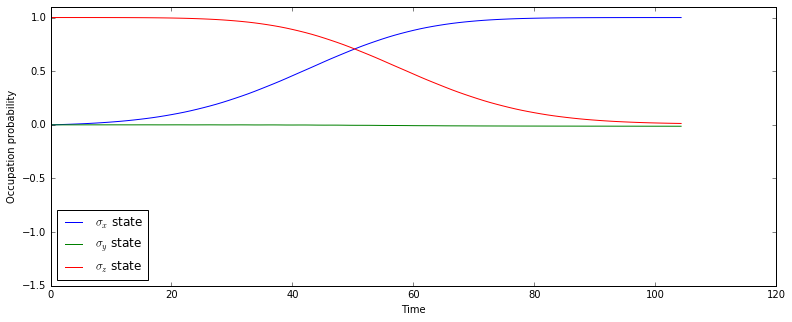

In [547]:
q3.plot()

In [ ]:
q3.fidelity()

In [59]:
q2 = SingleQND()
#q2.solveRF()
#q2.plot()

{'params': {'w': 33.398321459947766}}


In [60]:
q2.update_pulse(time = {'points': 100},params = {'phase': np.pi/2,'axe' : PulseNXY.aroundY})

{'params': {'axe': 1.5707963267948966, 'phase': 1.5707963267948966}, 'time': {'points': 100}}


{'params': {'width': 4, 'st': 0.3}}
10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.20s. Est. time left: 00:00:00:00
30.0%. Run time:   0.28s. Est. time left: 00:00:00:00
40.0%. Run time:   0.36s. Est. time left: 00:00:00:00
50.0%. Run time:   0.43s. Est. time left: 00:00:00:00
60.0%. Run time:   0.51s. Est. time left: 00:00:00:00
70.0%. Run time:   0.58s. Est. time left: 00:00:00:00
80.0%. Run time:   0.65s. Est. time left: 00:00:00:00
90.0%. Run time:   0.72s. Est. time left: 00:00:00:00
Total run time:   0.79s


(<matplotlib.figure.Figure at 0x7f9f3980e6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f37017f60>)

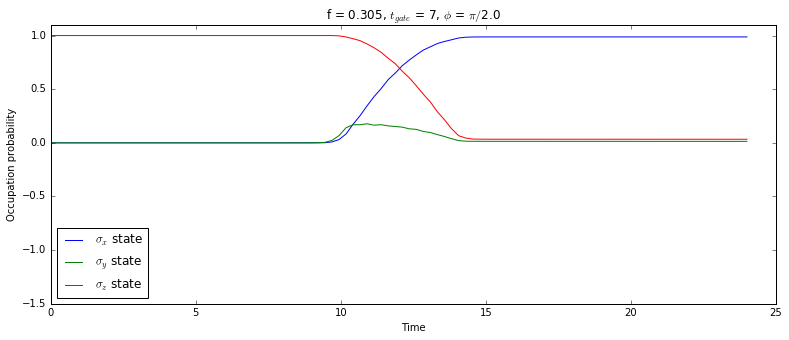

In [56]:
q2.update_pulse(params = {'width' : 4,'st':0.3}).solveRF()
q2.plot() 

In [50]:
q2.solve([])

10.0%. Run time:   1.15s. Est. time left: 00:00:00:10
20.0%. Run time:   2.31s. Est. time left: 00:00:00:09
30.0%. Run time:   3.40s. Est. time left: 00:00:00:07
40.0%. Run time:   4.43s. Est. time left: 00:00:00:06
50.0%. Run time:   5.50s. Est. time left: 00:00:00:05
60.0%. Run time:   6.53s. Est. time left: 00:00:00:04
70.0%. Run time:   7.56s. Est. time left: 00:00:00:03
80.0%. Run time:   8.63s. Est. time left: 00:00:00:02
90.0%. Run time:   9.67s. Est. time left: 00:00:00:01
Total run time:  10.65s


In [61]:
timesHTD = np.logspace(0.1,2,20)
realtimeHTD = []
fidsNHTD = []
for t in timesHTD:
    q2.update_pulse(params = {'width':t, 'st' : 1})
    fidsNHTD.append(q2.fidelity(q2.raise_dim_2toN(my_hadamard(), q2.I().data.toarray())) )
    realtimeHTD.append(q2.pulse[0].extra['b'] - q2.pulse[0].extra['a'])
    

{'params': {'width': 1.2589254117941673, 'st': 1}}
{}
{'params': {'width': 1.5848931924611136, 'st': 1}}
{}
{'params': {'width': 1.9952623149688795, 'st': 1}}
{}
{'params': {'width': 2.5118864315095801, 'st': 1}}
{}
{'params': {'width': 3.1622776601683795, 'st': 1}}
{}
{'params': {'width': 3.9810717055349722, 'st': 1}}
{}
{'params': {'width': 5.011872336272722, 'st': 1}}
{}
{'params': {'width': 6.3095734448019316, 'st': 1}}
{}
{'params': {'width': 7.9432823472428131, 'st': 1}}
{}
{'params': {'width': 9.9999999999999982, 'st': 1}}
{}
{'params': {'width': 12.589254117941667, 'st': 1}}
{}
{'params': {'width': 15.848931924611133, 'st': 1}}
{}
{'params': {'width': 19.952623149688797, 'st': 1}}
{}
{'params': {'width': 25.118864315095795, 'st': 1}}
{}
{'params': {'width': 31.622776601683793, 'st': 1}}
{}
{'params': {'width': 39.810717055349713, 'st': 1}}
{}
{'params': {'width': 50.118723362727224, 'st': 1}}
{}
{'params': {'width': 63.095734448019329, 'st': 1}}
{}
{'params': {'width': 79.43282

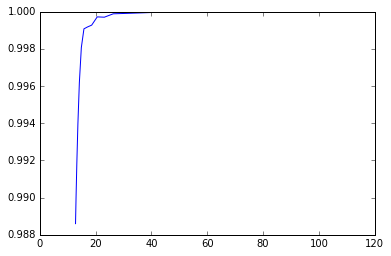

In [451]:
plt.plot(realtimeHTD,fidsNHTD)

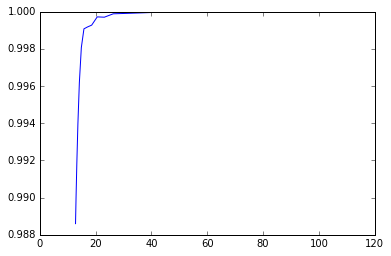

In [448]:
plt.plot(realtimeHTD, fidsNHTD)

In [392]:
q2.pulse[0].extra['b'] - q2.pulse[0].extra['a']

array([ 7.0980066])

In [83]:
realtimeGRAPE = [3,4,5]
fidsGRAPE = [1-2e-4,1-6e-5,1-5e-6]

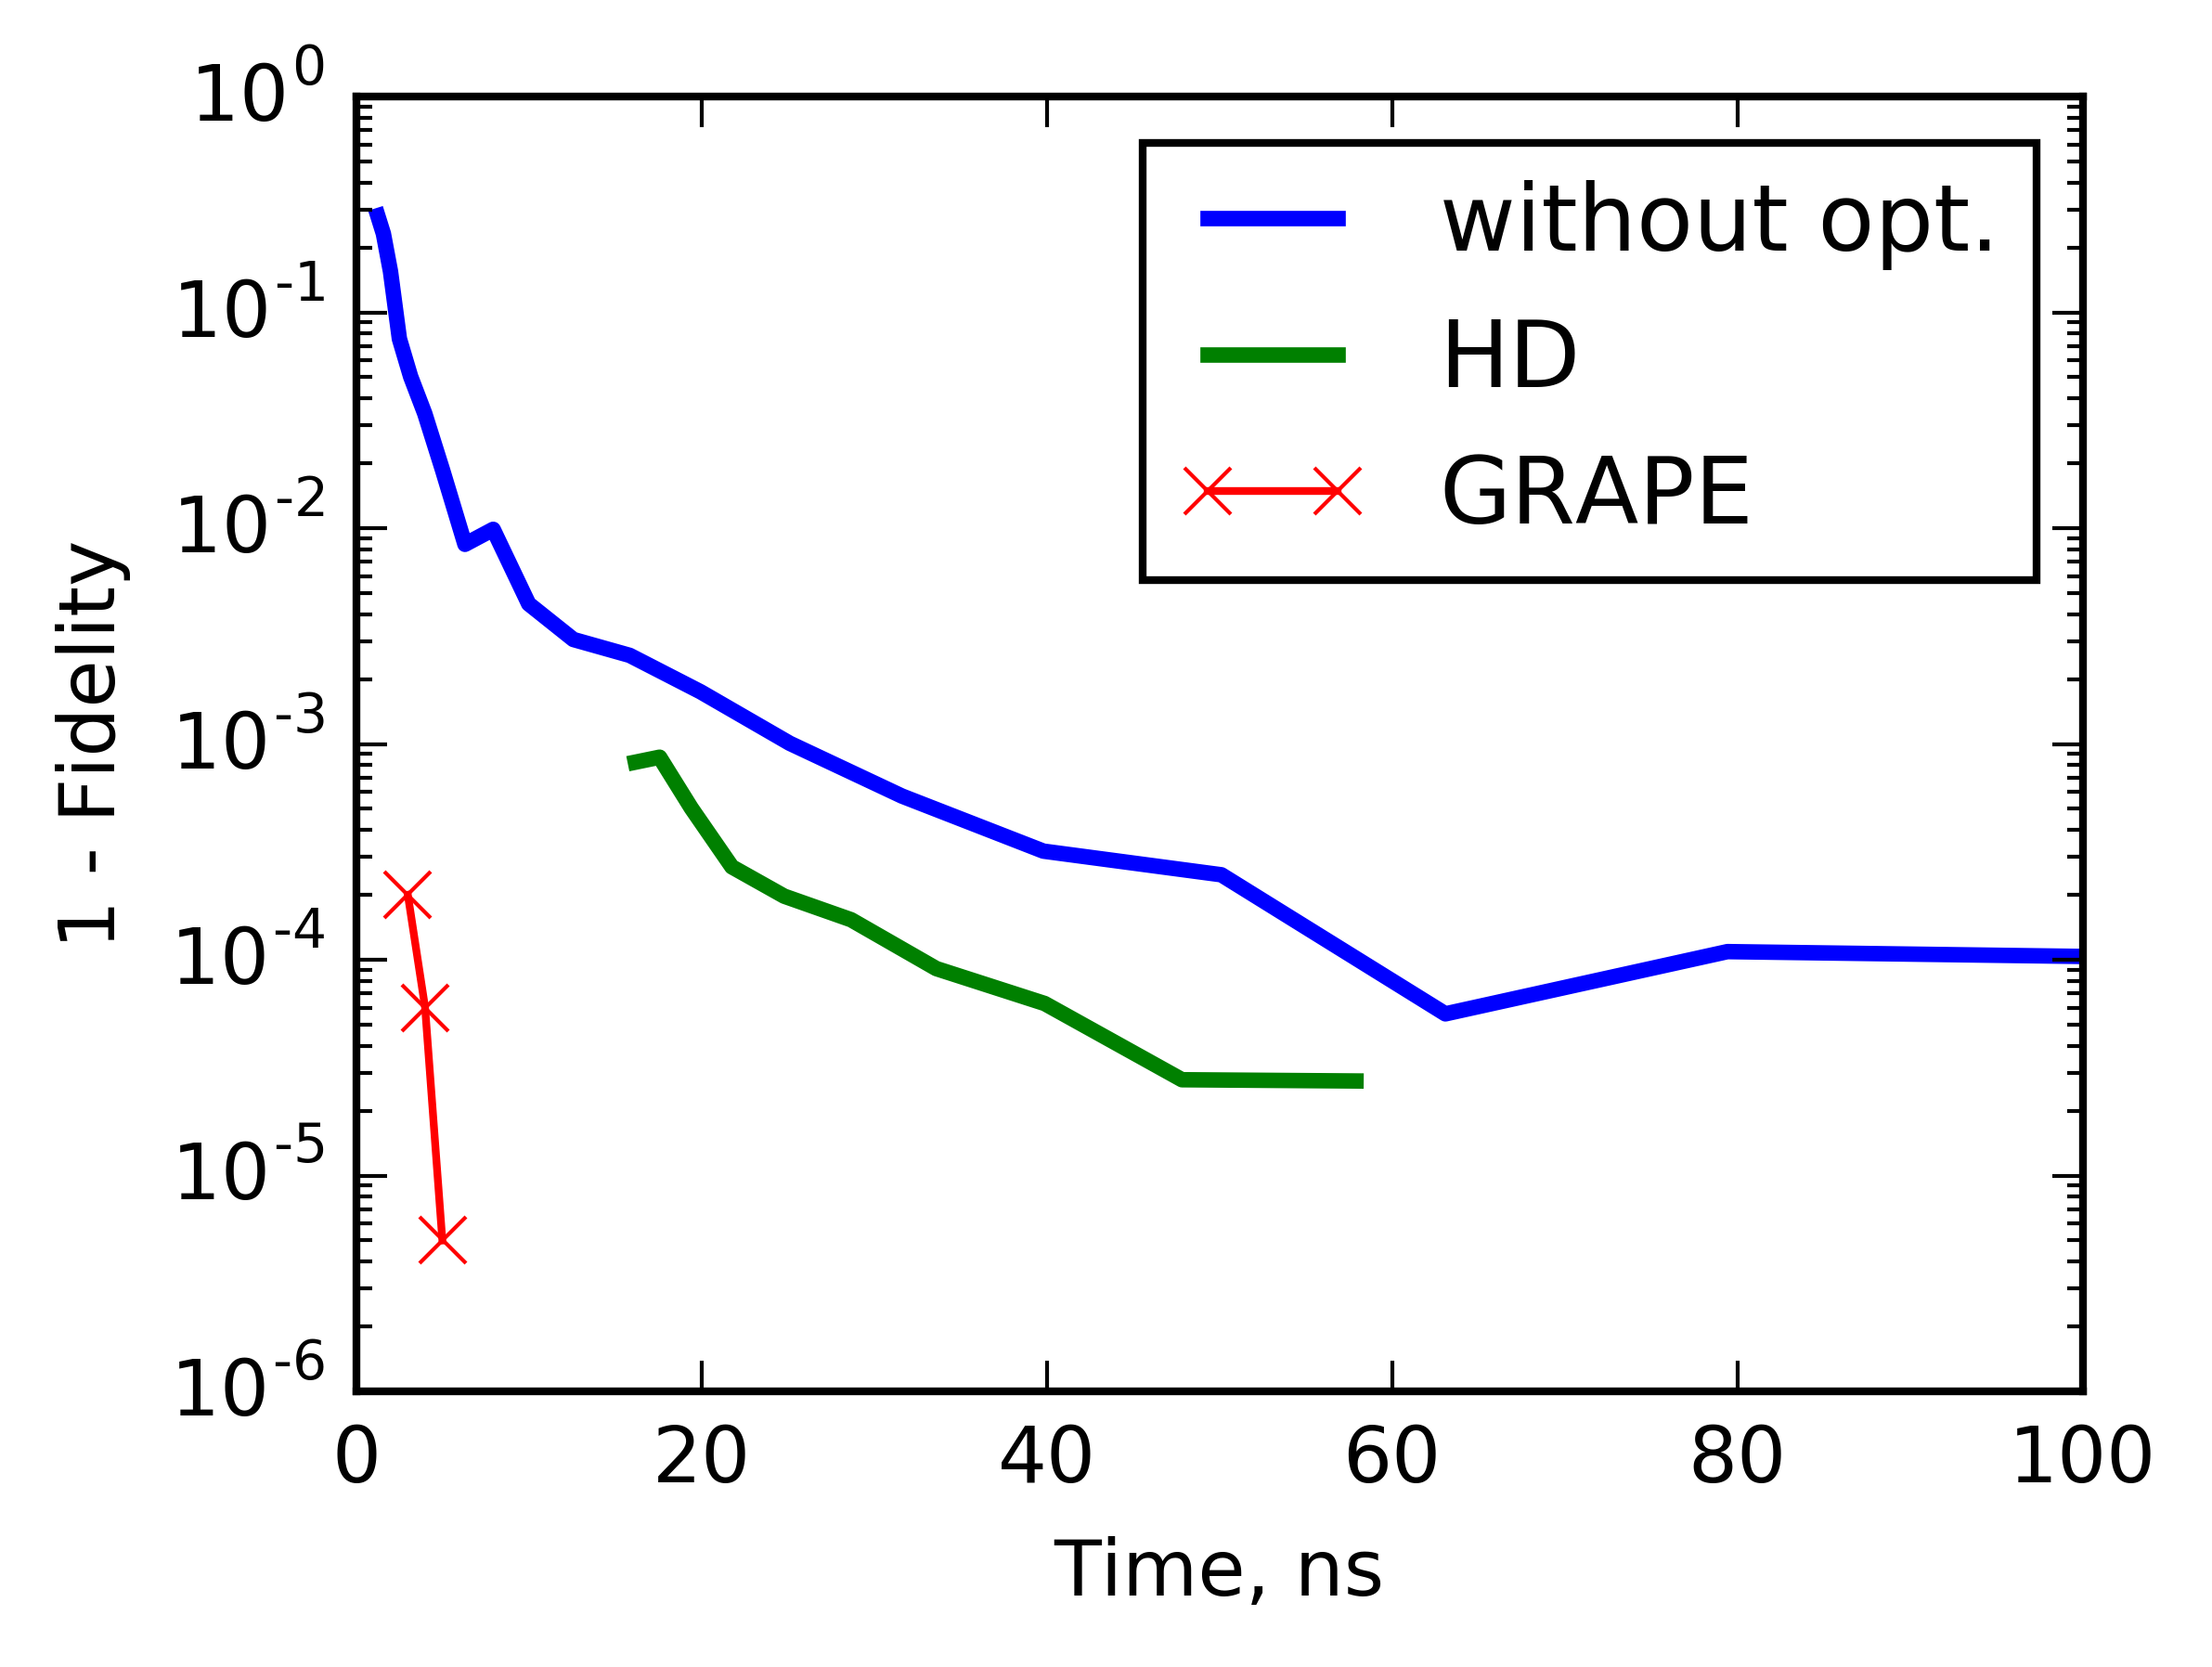

In [92]:
fig,ax = plt.subplots(1,figsize = (4,3), dpi = 600)
#ax.semilogy(times[30:], np.ones_like(fids[30:]) - fids[30:], linewidth = 2, label = 'simple 2d')
ax.semilogy(timesN,np.ones_like(fidsN) - fidsN, linewidth = 2, label ='without opt.')
ax.plot(realtimeHTD[7:-3],np.ones_like(fidsNHTD[7:-3]) - fidsNHTD[7:-3], linewidth = 2, label = 'HD')
ax.plot(realtimeGRAPE, fidsGRAPE,'x-', linewidth = 1, label = 'GRAPE')
#ax.plot(times, np.ones_like(times), 'r--', linewidth = 2)
#ax.set_ylim([0.75,1.05])
#ax.set_xlim([10,35])
ax.legend()
ax.set_xlabel('Time, ns')
ax.set_ylabel('1 - Fidelity')
plt.savefig('optimization_results.pdf', bbox_inches = 'tight')

In [116]:
q.fidelity(my_hadamard())

0.993440112364736

In [117]:
h = q.gate

In [110]:
g = q.gate

In [111]:
g

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.04040789+0.12419199j  0.20271567+0.94523724j]
 [ 0.20261800+0.94440964j -0.01381449-0.17352601j]]

## Hadamard = $X_{pi} Y_{pi/2}$

In [118]:
H = g*h

In [119]:
H0 = H.data.toarray()[0][0]

In [120]:
H = H * H0.conj() / abs(H0)

In [121]:
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.76878150+0.j          0.58889819-0.04450151j]
 [ 0.56411070+0.03345999j -0.79737886-0.01186625j]]

In [122]:
hadamard_transform()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

In [123]:
fidelity(H,hadamard_transform())/2

0.9834532552261406

In [68]:
spopt = SimplePropagator(timeslots = {'slots' : 4, 'eachtime' : 1},)

{'tlist': array([  0.,  10.]), 'points': 20, 'maxtime': 2, 'starttime': 0}


In [ ]:
spopt.count_gate()

In [107]:
def plot_parameters(pars):
    print(len(pars))
    duration = int(len(pars)/2)
    print(duration)
    sx_curve = pars[0:duration]
    sy_curve = pars[duration:]
    print(sx_curve)
    print(sy_curve)
    time = list(range(duration))
    print(time)
    sx_plot = [x for i in time for x in sx_curve[i]*np.ones(2) ]
    sy_plot = [y for i in time for y in sy_curve[i]*np.ones(2) ]
    print(sx_plot)
    print(sy_plot)
    print(time)
    time2 = [t for i in time for t in np.linspace(i,i+1,2) ]
    print(time2)
    fig,ax = plt.subplots(1, figsize=(3,1.5),dpi=600)
    ax.plot(time2,sx_plot,label=r"$f_x$",linewidth = 2)
    ax.plot(time2,sy_plot,label=r"$f_y$",linewidth = 2)
    ax.grid()
    ax.legend(loc = 'center')
    ax.set_xlabel('Time, ns')
    ax.set_ylabel('f, GHz')
    ax.set_ylim([min(sy_plot + sx_plot)-0.05,max(sy_plot + sx_plot)+0.05])

In [108]:
ps = [ 0.2366815 , 0.49748601, 0.49986014, 0.23515112, 0.06341888,
0.03429967, -0.03577362, -0.06288943]

8
4
[0.2366815, 0.49748601, 0.49986014, 0.23515112]
[0.06341888, 0.03429967, -0.03577362, -0.06288943]
[0, 1, 2, 3]
[0.23668149999999999, 0.23668149999999999, 0.49748600999999998, 0.49748600999999998, 0.49986014000000001, 0.49986014000000001, 0.23515111999999999, 0.23515111999999999]
[0.063418879999999997, 0.063418879999999997, 0.034299669999999997, 0.034299669999999997, -0.035773619999999999, -0.035773619999999999, -0.062889429999999996, -0.062889429999999996]
[0, 1, 2, 3]
[0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0]


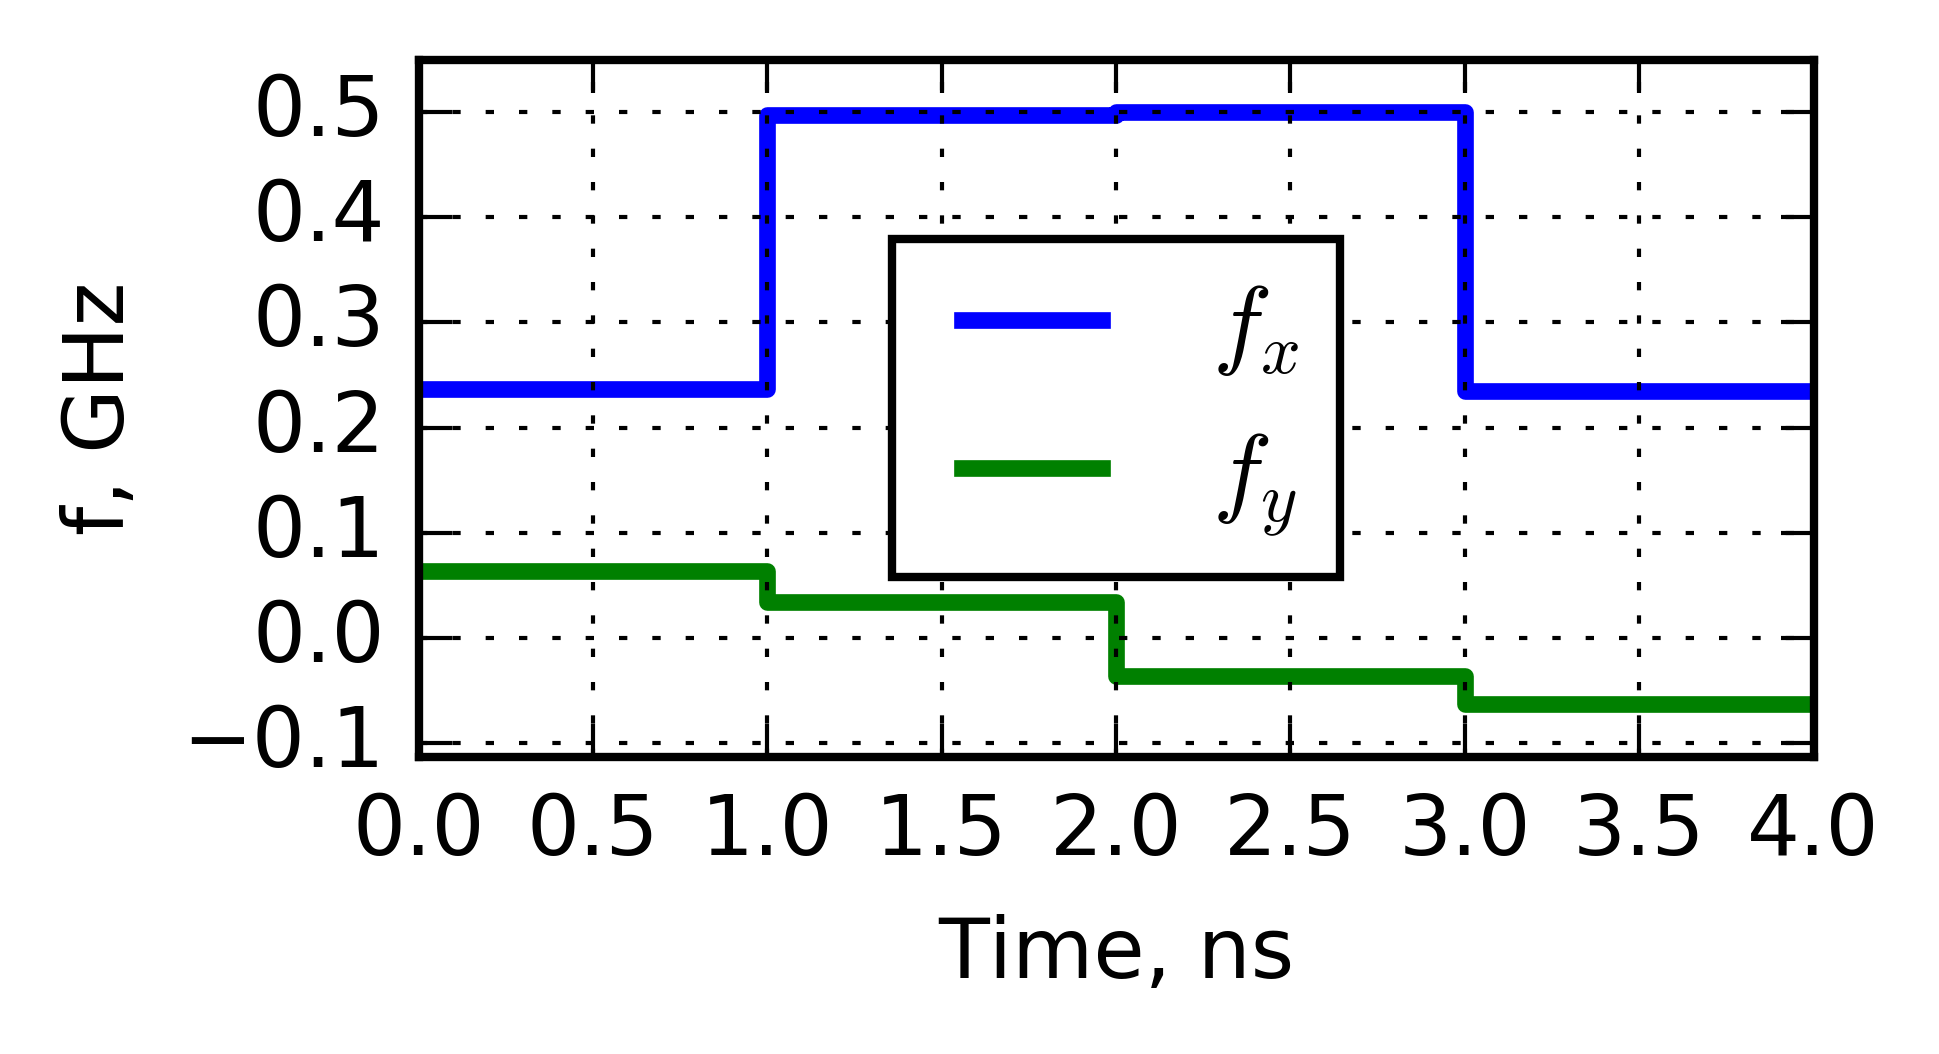

In [109]:
plot_parameters(ps)
plt.savefig('grape_pulse.pdf', bbox_inches = 'tight')

In [152]:
q2.update_pulse(params = {'width' : 10,'st' : 0.8})

{'params': {'width': 10, 'st': 0.8}}


In [153]:
q2.pulse[0].shape

'0.22821600457627*f*((-tanh((-a + t)/st)**2 + 1)/st - (-tanh((-b + t)/st)**2 + 1)/st)*sin(axe + t*w) + 0.5*f*(tanh((-a + t)/st) - tanh((-b + t)/st))*cos(axe + t*w)'

In [154]:
sh = sp.sympify(q2.pulse[0].shape)

In [155]:
axe,w,a,b,st,f = sp.symbols('axe w a b st f')
shape_x = sh.subs(axe, 0).subs(w,0).subs(a,q2.pulse[0].params['a']).subs(b,q2.pulse[0].params['b']).subs(st,q2.pulse[0].params['st']).subs(f,q2.pulse[0].params['f'])
shape_y = sh.subs(axe, np.pi/2).subs(w,0).subs(a,q2.pulse[0].params['a']).subs(b,q2.pulse[0].params['b']).subs(st,q2.pulse[0].params['st']).subs(f,q2.pulse[0].params['f'])

In [156]:
shape_x,shape_y

(-0.061075653615479*tanh(1.25*t - 25.0) + 0.061075653615479*tanh(1.25*t - 12.5),
 0.0348461041125221*tanh(1.25*t - 25.0)**2 - 3.73980518530144e-18*tanh(1.25*t - 25.0) - 0.0348461041125221*tanh(1.25*t - 12.5)**2 + 3.73980518530144e-18*tanh(1.25*t - 12.5))

In [157]:
sh_x = lambdify({'t'},shape_x,'numpy')
sh_y = lambdify({'t'},shape_y,'numpy')

In [163]:
t = np.linspace(5, 25, 100)

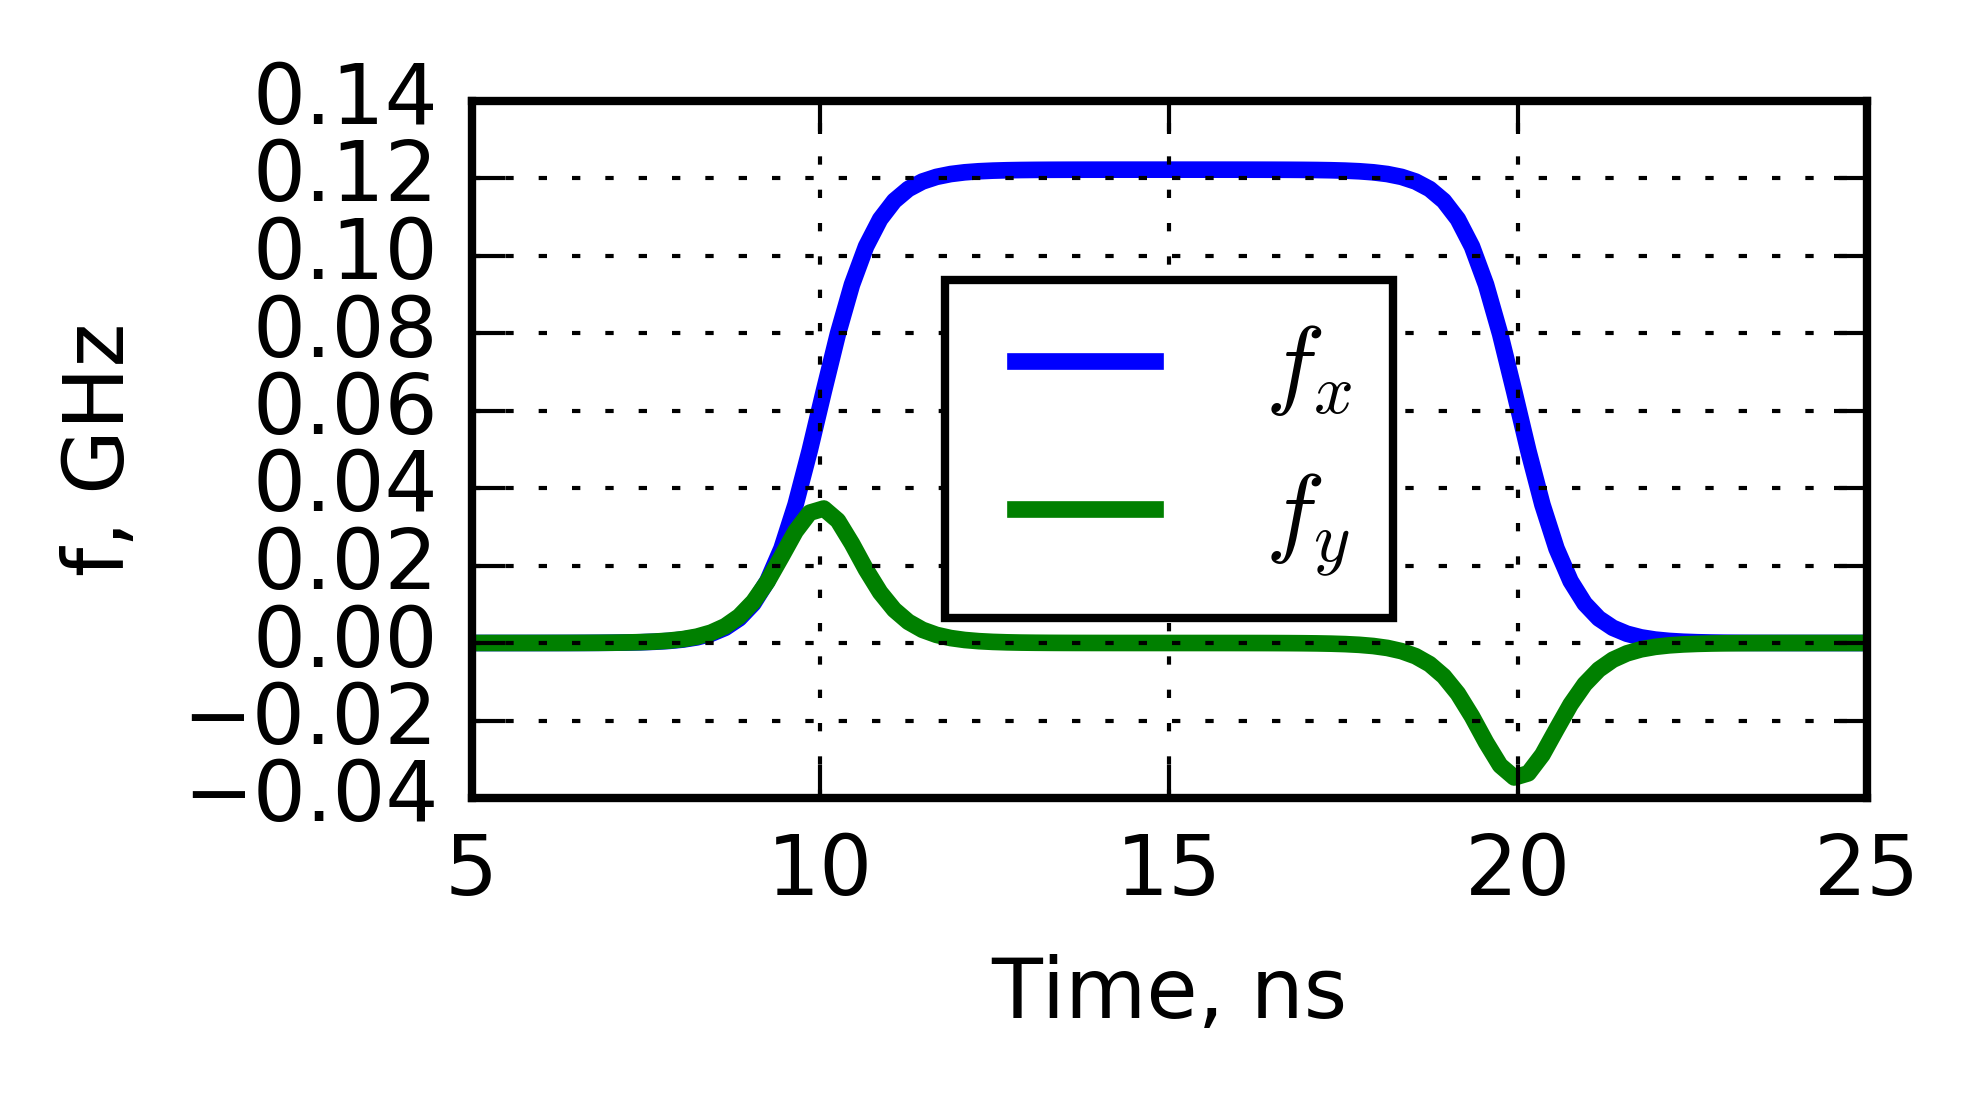

In [169]:
fig,ax = plt.subplots(1, figsize=(3,1.5),dpi=600)
ax.plot(t,sh_x(t),label=r"$f_x$",linewidth = 2)
ax.plot(t,sh_y(t),label=r"$f_y$",linewidth = 2)
ax.grid()
ax.legend(loc = 'center')
ax.set_xlabel('Time, ns')
ax.set_ylabel('f, GHz')
#ax.set_ylim([min(sy_plot + sx_plot)-0.05,max(sy_plot + sx_plot)+0.05])
plt.savefig('hd-example.pdf',bbox_inches = 'tight')

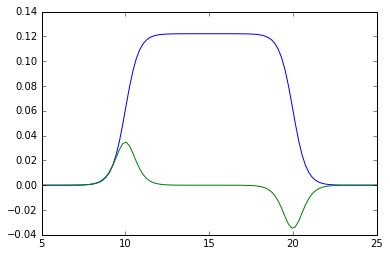